In [2]:
### Running bias tests for gamma = 2,3 and different time windows

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import argparse
import histlite as hl
import csky as cy
from icecube.icetray import I3Units
from icecube import dataclasses,astro
import random

cy.plotting.mrichman_mpl()

timer = cy.timing.Timer()
time = timer.time

#Building/loading MESC data from analysis directory

ana_dir = cy.utils.ensure_dir('/data/user/mkovacevich/FRB_analysis/cascades_ana')
repo = cy.selections.Repository()
ana = cy.get_analysis(repo, cy.selections.MESEDataSpecs.mesc_7yr, dir=ana_dir)

Setting up Analysis for:
MESC_2010_2016
Setting up MESC_2010_2016...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC86_2013_MC.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC79_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC86_2011_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC86_2012_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC86_2013_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC86_2014_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC86_2015_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/IC86_2016_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/GRL/IC79_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/GRL/IC86_2011_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/mese_cascades/version-001-p02/GRL/

0.01
int64
Performing 100 trials with n_sig = 2.000 using 10.0 cores:
        100/100 trials complete.   
Performing 100 trials with n_sig = 3.000 using 10.0 cores:
        100/100 trials complete.   
Performing 100 trials with n_sig = 4.000 using 10.0 cores:
        100/100 trials complete.   
Performing 100 trials with n_sig = 5.000 using 10.0 cores:
        100/100 trials complete.   
Performing 100 trials with n_sig = 6.000 using 10.0 cores:
        100/100 trials complete.   
Performing 100 trials with n_sig = 7.000 using 10.0 cores:
        100/100 trials complete.   
Performing 100 trials with n_sig = 8.000 using 10.0 cores:
        100/100 trials complete.   
Performing 100 trials with n_sig = 9.000 using 10.0 cores:
        100/100 trials complete.   

0:03:25.181494 elapsed.


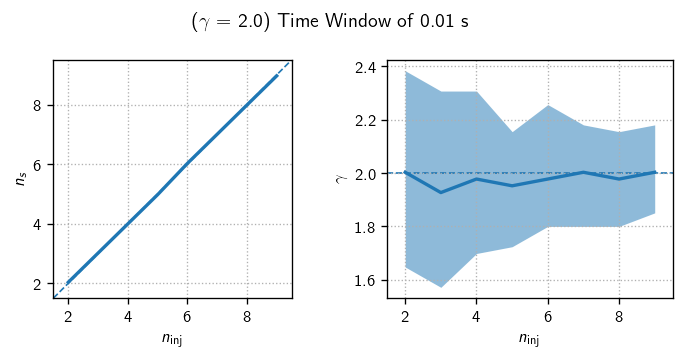

In [13]:
#Looking at gamma = 2

time_dt = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]
for i in time_dt:
    print(i)
    cy.CONF['ana'] = ana
    cy.CONF['mp_cpus'] = 10.0

    FRB_mjd_time = [57760.83732799769, 57547.161818148146, 57488.35670925926, 57464.37542280093, 57389.35323349537, 57386.67762181713, 57362.262416412035, 57241.74578506944, 57183.22707634259, 57130.18688260417, 57068.86228835648, 56791.718183564815, 56600.752907407405, 56502.376286921295, 56471.165279837965, 56469.62221957176, 56202.5481300463, 55953.341223668984, 55745.79144221065, 55738.89811894676, 55704.629394675925, 55612.080417777775]

    FRB_ra_rad = [2.979102500229121, 1.992642407001926, 2.2750366799746087, 2.0673424989872835, 5.928883469024737, 2.534392606820966, 5.067563483165536, 5.945115031068284, 2.811899957888065, 1.9050268785518107, 4.788485335771643, 5.9082885838512045, 1.7634806762150708, 3.5838590860451562, 2.369458992507502, 4.306948995146407, 4.776966162708479, 6.087184832180623, 6.1559508047091995, 5.514018705825685, 5.695009349257497, 5.910732044803997]

    FRB_dec_rad = [-0.08691739674931762, -0.6841690667817772, 0.10611601852125524, -0.4954989746411902, -0.5204571829447091, -0.0445058959258554, -0.06754424205218056, -0.9585348251952858, -0.6965609044709369, -0.33143802495372315, -0.054105206811824215, -0.2040289895581371, -0.8852309966115239, -0.06981317007977318, 0.060039326268604934, -0.11414453308042916, -1.4800392056911915, -0.3066543495754037, -0.01972222054753592, -0.755029434412747, 0.00027925268031909274, -0.20245819323134223]

    gamma = 2.0
    dt = i
    FRB_time_window = np.ones_like(FRB_ra_rad)*dt/86400.

    #using a random seed enables the use of different MC when scrambling
    rand_seed = random.randint(0, 1e5)

    src = cy.sources(FRB_ra_rad, FRB_dec_rad, mjd = FRB_mjd_time, sigma_t = np.zeros_like(FRB_ra_rad), t_100 = FRB_time_window)
    conf = {'extended':True, 'space':"ps",'time':"transient",'sig':"transient",'flux': cy.hyp.PowerLawFlux(gamma)}
    tr = cy.get_trial_runner(conf, src = src, ana=ana)

    n_sigs = np.r_[2:10:1] #, 10:31:2]
    print(n_sigs.dtype)
    with time('ps fit bias trials'):
        trials = [tr.get_many_fits(100, n_sig=n_sig, logging=True, seed=random.randint(0, 1e5), poisson = False) for n_sig in n_sigs]

    for (n_sig, t) in zip(n_sigs, trials):
        t['ntrue'] = np.repeat(n_sig, len(t))

    allt = cy.utils.Arrays.concatenate(trials)

    fig, axs = plt.subplots(1, 2, figsize=(6,3)) 

    dns = np.mean(np.diff(n_sigs))
    ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
    expect_kw = dict(color='C0', ls='--', lw=1, zorder=-10)
    expect_gamma = tr.sig_injs[0].flux[0].gamma

    ax = axs[0]
    h = hl.hist((allt.ntrue, allt.ns), bins=(ns_bins, 100))
    hl.plot1d(ax, h.contain_project(1),errorbands=True, drawstyle='default')

    lim = ns_bins[[0, -1]]
    ax.set_xlim(ax.set_ylim(lim))
    ax.plot(lim, lim, **expect_kw)
    ax.set_aspect('equal')


    ax = axs[1]
    h = hl.hist((allt.ntrue, allt.gamma), bins=(ns_bins, 100))
    hl.plot1d(ax, h.contain_project(1),errorbands=True, drawstyle='default')
    ax.axhline(expect_gamma, **expect_kw)
    ax.set_xlim(axs[0].get_xlim())

    for ax in axs:
        ax.set_xlabel(r'$n_\text{inj}$')
        ax.grid()
    axs[0].set_ylabel(r'$n_s$')
    axs[1].set_ylabel(r'$\gamma$')
    ax.wspace = 1.0
    plt.suptitle(r'($\gamma$ = '+str(gamma) + ') Time Window of '+str(dt)+ ' s' ) #set_title(r'$\gamma$' = 3) #= 3 & Time Window of 0.01 s')
    plt.subplots_adjust(wspace = .5, bottom=0.15)
    plt.savefig('/home/mkovacevich/public_html/plots/BiasTest_Gamma_'+str(gamma)+'_dt_'+str(dt)+'.png')
    plt.tight_layout()

In [ ]:
#Looking at gamma = 3

time_dt = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]
for i in time_dt:
    print(i)
    cy.CONF['ana'] = ana
    cy.CONF['mp_cpus'] = 10.0

    FRB_mjd_time = [57760.83732799769, 57547.161818148146, 57488.35670925926, 57464.37542280093, 57389.35323349537, 57386.67762181713, 57362.262416412035, 57241.74578506944, 57183.22707634259, 57130.18688260417, 57068.86228835648, 56791.718183564815, 56600.752907407405, 56502.376286921295, 56471.165279837965, 56469.62221957176, 56202.5481300463, 55953.341223668984, 55745.79144221065, 55738.89811894676, 55704.629394675925, 55612.080417777775]

    FRB_ra_rad = [2.979102500229121, 1.992642407001926, 2.2750366799746087, 2.0673424989872835, 5.928883469024737, 2.534392606820966, 5.067563483165536, 5.945115031068284, 2.811899957888065, 1.9050268785518107, 4.788485335771643, 5.9082885838512045, 1.7634806762150708, 3.5838590860451562, 2.369458992507502, 4.306948995146407, 4.776966162708479, 6.087184832180623, 6.1559508047091995, 5.514018705825685, 5.695009349257497, 5.910732044803997]

    FRB_dec_rad = [-0.08691739674931762, -0.6841690667817772, 0.10611601852125524, -0.4954989746411902, -0.5204571829447091, -0.0445058959258554, -0.06754424205218056, -0.9585348251952858, -0.6965609044709369, -0.33143802495372315, -0.054105206811824215, -0.2040289895581371, -0.8852309966115239, -0.06981317007977318, 0.060039326268604934, -0.11414453308042916, -1.4800392056911915, -0.3066543495754037, -0.01972222054753592, -0.755029434412747, 0.00027925268031909274, -0.20245819323134223]

    gamma = 3.0
    dt = i
    FRB_time_window = np.ones_like(FRB_ra_rad)*dt/86400.

    #using a random seed enables the use of different MC when scrambling
    rand_seed = random.randint(0, 1e5)

    src = cy.sources(FRB_ra_rad, FRB_dec_rad, mjd = FRB_mjd_time, sigma_t = np.zeros_like(FRB_ra_rad), t_100 = FRB_time_window)
    conf = {'extended':True, 'space':"ps",'time':"transient",'sig':"transient",'flux': cy.hyp.PowerLawFlux(gamma)}
    tr = cy.get_trial_runner(conf, src = src, ana=ana)

    n_sigs = np.r_[2:10:1] #, 10:31:2]
    print(n_sigs.dtype)
    with time('ps fit bias trials'):
        trials = [tr.get_many_fits(100, n_sig=n_sig, logging=True, seed=random.randint(0, 1e5), poisson = False) for n_sig in n_sigs]

    for (n_sig, t) in zip(n_sigs, trials):
        t['ntrue'] = np.repeat(n_sig, len(t))

    allt = cy.utils.Arrays.concatenate(trials)

    fig, axs = plt.subplots(1, 2, figsize=(6,3)) 

    dns = np.mean(np.diff(n_sigs))
    ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
    expect_kw = dict(color='C0', ls='--', lw=1, zorder=-10)
    expect_gamma = tr.sig_injs[0].flux[0].gamma

    ax = axs[0]
    h = hl.hist((allt.ntrue, allt.ns), bins=(ns_bins, 100))
    hl.plot1d(ax, h.contain_project(1),errorbands=True, drawstyle='default')

    lim = ns_bins[[0, -1]]
    ax.set_xlim(ax.set_ylim(lim))
    ax.plot(lim, lim, **expect_kw)
    ax.set_aspect('equal')


    ax = axs[1]
    h = hl.hist((allt.ntrue, allt.gamma), bins=(ns_bins, 100))
    hl.plot1d(ax, h.contain_project(1),errorbands=True, drawstyle='default')
    ax.axhline(expect_gamma, **expect_kw)
    ax.set_xlim(axs[0].get_xlim())

    for ax in axs:
        ax.set_xlabel(r'$n_\text{inj}$')
        ax.grid()
    axs[0].set_ylabel(r'$n_s$')
    axs[1].set_ylabel(r'$\gamma$')
    ax.wspace = 1.0
    plt.suptitle(r'($\gamma$ = '+str(gamma) + ') Time Window of '+str(dt)+ ' s' ) #set_title(r'$\gamma$' = 3) #= 3 & Time Window of 0.01 s')
    plt.subplots_adjust(wspace = .5, bottom=0.15)
    plt.savefig('/home/mkovacevich/public_html/plots/BiasTest_Gamma_'+str(gamma)+'_dt_'+str(dt)+'.png')
    plt.tight_layout()